In [23]:
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os
# Visualization
from IPython.display import Image, display
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [24]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), int(nGraphPerRow), i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [25]:
df = pd.read_csv('signlanguagemnist\sign_mnist_train\sign_mnist_train.csv')
df.dataframeName = 'sign_mnist_test.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 27455 rows and 785 columns


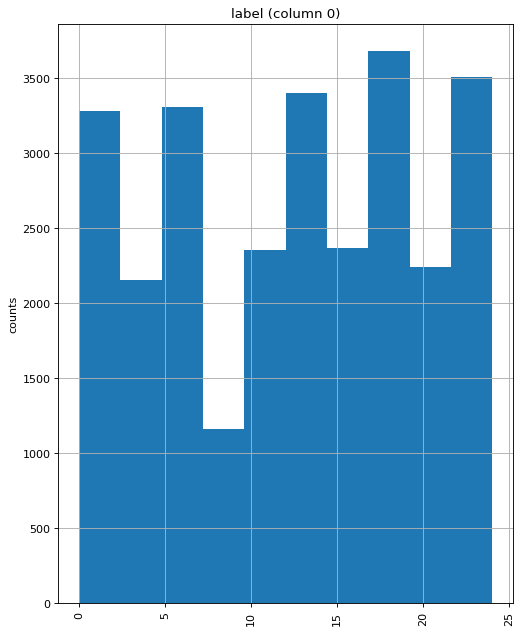

In [26]:
plotPerColumnDistribution(df, 10, 5)

In [27]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [28]:
train = pd.read_csv('signlanguagemnist\sign_mnist_train\sign_mnist_train.csv')
test = pd.read_csv('signlanguagemnist\sign_mnist_test\sign_mnist_test.csv')


train = train[train['label'].isin( [21, 11, 0, 22, 17, 14, 4, 3,7])]
test = test[test['label'].isin( [21, 11, 0, 22, 17, 14, 4, 3,7])]

train['label'] = train['label'].map({21:0, 11:1, 0:2, 22:3, 17:4, 14:5, 4:6, 3:7, 7:8})
test['label'] = test['label'].map({21:0, 11:1, 0:2, 22:3, 17:4, 14:5, 4:6, 3:7, 7:8})

images, labels = train.iloc[:, 1:], train['label']
testImages, testLabels = test.iloc[:, 1:], test['label']


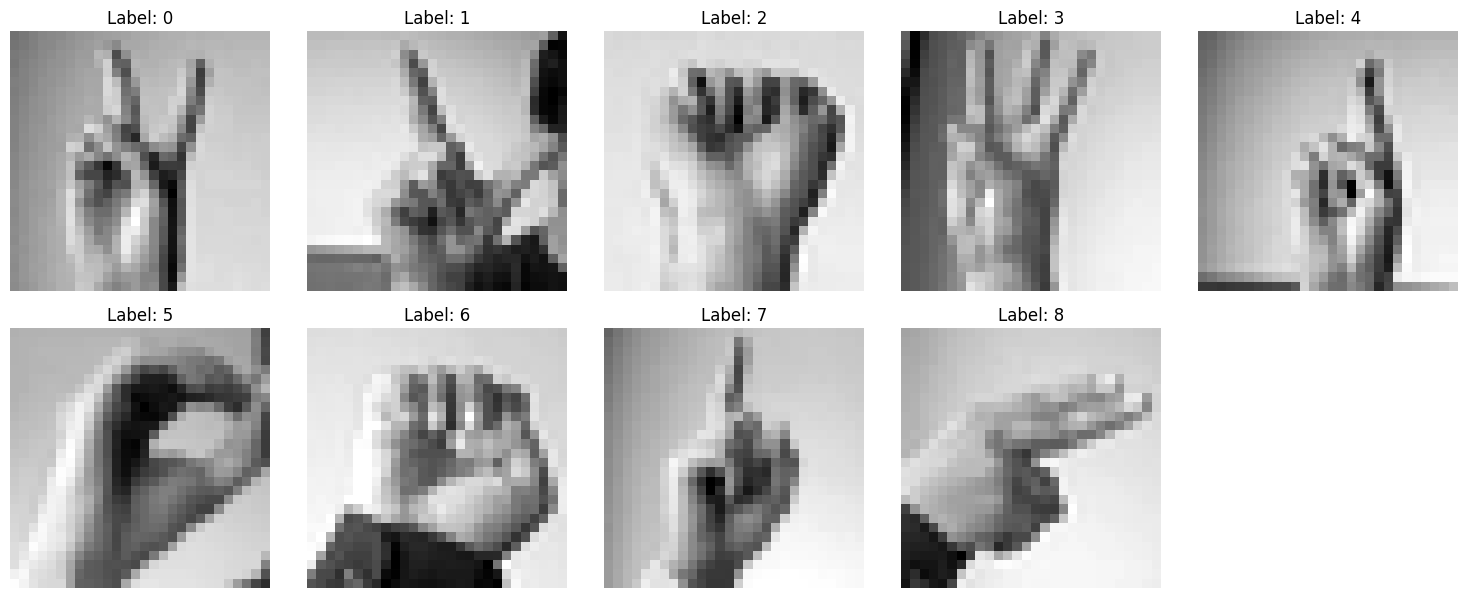

In [29]:
# Displaying one image for each class
def displayImgForEveryClass(images, labels):
    plt.figure(figsize=(15, 15))  # Adjust the figure size as necessary

    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        # Find the first occurrence of the label
        index = labels[labels == label].index[0]
        
        # Extract the corresponding image
        img = images.loc[index].values.reshape(28, 28)
        
        plt.subplot(5, 5, i + 1)  # Adjust grid size based on the number of unique labels
        plt.title(f'Label: {label}')
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# K, J A, W, R, O, E, D, H
# Call the function to display the images
displayImgForEveryClass(images, labels)


In [1]:
mpHands = mp.solutions.hands

hands = mpHands.Hands(static_image_mode=True,
                      max_num_hands=1,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.5,
                      model_complexity = 1)
mpDraw = mp.solutions.drawing_utils

def draw_bounding_box_around_gesture(image):
    
    rows, cols = np.where(image > 0)
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        h, w = img.shape
        min_x, min_y = w, h
        max_x, max_y = 0, 0
        for id, lm in enumerate(results.multi_hand_landmarks[0].landmark):
            # Convert the normalized position to pixel coordinates
            cx, cy = int(lm.x * w), int(lm.y * h)

            # Update min and max coordinates based on current landmark
            min_x, min_y = min(min_x, cx), min(min_y, cy)
            max_x, max_y = max(max_x, cx), max(max_y, cy)
        
        center_x, center_y = (min_x + max_x) // 2, (min_y + max_y) // 2
        width, height = 1.3*(max_x - min_x), 1.3*(max_y - min_y)
        
        new_min_x, new_min_y = int(center_x - width / 2), int(center_y -  height / 2)
        new_max_x, new_max_y = int(center_x + width / 2), int(center_y +  height / 2)
        cv2.rectangle(img, (new_min_x, new_min_y), (new_max_x, new_max_y), (255, 255, 25), 1)
        plt.title(f'Label: {labels.iloc[index]}')
        plt.imshow(image, cmap='gray')
        plt.show()
    else:
        print('no hand detected')



def display_image(index):   
    
    plt.title(f'Label: {labels[index]}')
    plt.imshow(images.loc[index].values.reshape(28, 28), cmap='gray')
    plt.show()



index = 0  # Example index
unique_labels = np.unique(labels)
for index in range(len(np.array(labels))):
    # Find the first occurrence of the label
    img = images.iloc[index].values.reshape(28, 28).astype(np.uint8)
    
    draw_bounding_box_around_gesture(img)
    label = labels.iloc[index]
    plt.title(f'Label: {labels.iloc[index]}')
    #plt.imshow(img, cmap='gray')
    plt.axis('off')
    #plt.show()





NameError: name 'mp' is not defined

In [38]:




labels = to_categorical(labels, num_classes = 9)
testLabels = to_categorical(testLabels, num_classes = 9)
# Train-test validation split
trainX, testX, trainY, testY = train_test_split(images, labels, random_state = 0)
# Reshaping data and scaling it from 0 to 1
trainX, testX, testImages = [data.to_numpy().reshape(-1, 28, 28, 1) / 255 for data in [trainX, testX, testImages]]

In [39]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

testDatagen = ImageDataGenerator()

trainGen = datagen.flow(trainX, trainY, batch_size = 512)
validGen = testDatagen.flow(testX, testY, batch_size = 512)
testGen = testDatagen.flow(testImages, testLabels, batch_size = 512)

In [43]:
model = Sequential([
    layers.Conv2D(64, (5, 5), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
    layers.Conv2D(64, (5, 5), activation = 'relu', padding = 'same'),
    layers.MaxPool2D(2),
    
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPool2D(2),
    
    layers.Dropout(0.2),
    layers.Flatten(),
    
    layers.Dense(256, activation = 'relu'),
    
    layers.Dropout(0.2),
    
    layers.Dense(9, activation = 'softmax')
])

# Defining optimizer, loss, and metrics
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Summary of model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        9248      
                                                      

In [44]:
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 1e-4,
    patience = 5,
    restore_best_weights = True
)
# Adding a learning rate annealer
reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 3,
    factor = 0.5,
    min_lr = 1e-5
)
# Training model
history = model.fit(
    trainGen,
    validation_data = validGen,
    epochs = 20,
    callbacks = [earlyStopping, reduceLR],
    workers = 4,
    use_multiprocessing = False)

Epoch 1/20
16/16 [==============================] - 30s 2s/step - loss: 2.1755 - accuracy: 0.1493 - val_loss: 1.9856 - val_accuracy: 0.2296 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - 32s 2s/step - loss: 1.9699 - accuracy: 0.2771 - val_loss: 1.2576 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - 35s 2s/step - loss: 1.5432 - accuracy: 0.4433 - val_loss: 0.9516 - val_accuracy: 0.7131 - lr: 0.0010
Epoch 4/20
16/16 [==============================] - 38s 2s/step - loss: 1.2696 - accuracy: 0.5447 - val_loss: 0.6497 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 5/20
16/16 [==============================] - 39s 2s/step - loss: 1.0638 - accuracy: 0.6165 - val_loss: 0.8331 - val_accuracy: 0.7015 - lr: 0.0010
Epoch 6/20
16/16 [==============================] - 37s 2s/step - loss: 0.9095 - accuracy: 0.6737 - val_loss: 0.4386 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 7/20
16/16 [==============================] - 37s 2s/step - loss: 0.7656 - a

In [45]:
testAcc = model.evaluate(testGen)[1] * 100
print(f'Testing accuracy of model : {testAcc:.2f}%')
model.save('ASLModelV2.h5')

6/6 [==============================] - 2s 328ms/step - loss: 0.0151 - accuracy: 1.0000
Testing accuracy of model : 100.00%


In [48]:
Model=load_model('ASLModelV2.h5')
testAcc = Model.evaluate(testGen)[1] 
print(f'Testing accuracy of model : {testAcc:.2f}%')

6/6 [==============================] - 3s 387ms/step - loss: 0.0151 - accuracy: 1.0000
Testing accuracy of model : 1.00%
